# Popularity Prediction
## Problem 1.1
As a preliminary step, we calculated the following statistics to get a holistic overview of the twitter dataset.

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

In [137]:
data_dir = 'tweet_data' # MAKE SURE TO CHANGE THIS TO WHERE EVER YOUR DATA IS. 
# The total data size is ~14gb which is too large to be committed into github

# Puts data into dict
# hashtags = ['gohawks', 'gopatriots', 'nfl', 'patriots', 'sb49', 'superbowl'] 
# this takes awhile so use toy example of #gopatriots only
hashtags = ['gopatriots']
data = {}
for hashtag in hashtags:
    file_name = data_dir + '/tweets_#' + hashtag + '.txt' 
    with open(file_name, 'r') as f:
        tweets = []
        for i, l in enumerate(f):
            tweet = json.loads(l)
            tweets.append(tweet)
        data[hashtag] = tweets

In [138]:
#print(data['gopatriots'][0])
#print(data['gopatriots'][0]['metrics']['impressions'])
#for item in data['gopatriots'][0].items():
 #   print(item)

In [139]:
for hashtag in hashtags:
    total_tweets = len(data[hashtag])
    min_utc = data[hashtag][0]['citation_date']
    max_utc = data[hashtag][-1]['citation_date']
    total_hours = (max_utc - min_utc) // 3600
    
    total_retweets = 0
    
    total_followers = 0
    users = {}
    for tweet in data[hashtag]:
        user_id = tweet['tweet']['user']['id']
        total_retweets += tweet['metrics']['citations']['total']
        if user_id in users: continue # user already encountered
        users[user_id] = True
        total_followers += tweet['author']['followers']
    total_users = len(users)
    
    print('#%s' % hashtag)
    print('\tAvg # of tweets / hour = %.3f' % (total_tweets / total_hours))
    print('\tAvg # of followers / user = %.3f' % (total_followers / total_users))
    print('\tAvg # of retweets / tweet = %.3f' % (total_retweets / total_tweets))

#gopatriots
	Avg # of tweets / hour = 46.346
	Avg # of followers / user = 1298.824
	Avg # of retweets / tweet = 1.400


### a) Here, we show histograms with 1-hour bins that show the number the tweets in hour over time for two hashtag groups, #SuperBowl and #NFL. 

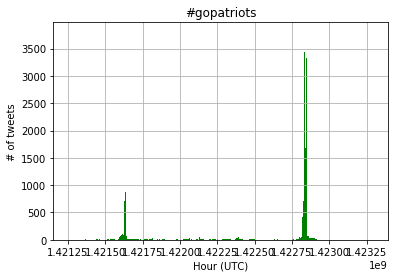

In [140]:
import datetime, time
import pytz
hashtag_dict = {}
for hashtag in hashtags:
    total_tweets = len(data[hashtag])
    hashtag_dict[hashtag] = total_tweets
    min_utc = data[hashtag][0]['citation_date']//3600*3600
    max_utc = data[hashtag][-1]['citation_date']//3600*3600
#     print(min_utc, max_utc)
    bins = np.arange(min_utc, max_utc+3600, 3600)
    x = []
    for tweet in data[hashtag]:
        x.append(tweet['citation_date'])
    
    n, b, p = plt.hist(x, bins, facecolor='g')
#     print(b,p)
    plt.xlabel('Hour (UTC)')
    plt.ylabel('# of tweets')
    plt.title('#' + hashtag)
#     plt.axis([40, 160, 0, 0.03])
    plt.grid(True)
    plt.show()

## Problem 1.2
For each hashtag, we first fitted a linear regression model using the following five features to
predict the number of tweets in the next hour, with features extracted from tweet data in
the previous hour.
The features we used are:
* Number of tweets (hashtag of interest)
* Total number of retweets (hashtag of interest)
* Sum of the number of followers of the users posting the hashtag
* Maximum number of followers of the users posting the hashtag
* Time of the day (which could take 24 values that represent hours of the day with respect to a given time zone)

For each model, we present the training accuracy and r2 score. Further, we analyzed the significance of each feature using the t-test and P-value, using a third-party statsmodels.api.

In [141]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime, time
import pytz
from itertools import compress
from sklearn import datasets, linear_model
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error

pst_tz = pytz.timezone('US/Pacific')

for hashtag in hashtags:
    total_tweets = len(data[hashtag])
    min_utc = data[hashtag][0]['citation_date']//3600*3600
    max_utc = data[hashtag][-1]['citation_date']//3600*3600
    bins = np.arange(min_utc, max_utc+3600, 3600) # [0, 5, 10, 15]
    
#     X = np.zeros((len(bins) - 2, 6))
    bin_data = {}

    post_times = [tweet['citation_date'] for tweet in data[hashtag]]
    inds = np.digitize(post_times, bins)
    for i in range(total_tweets):
        bin_num = inds[i] # tweet is in this bin num : bins[inds[n]-1] <= tweet < bins[inds[n]]
        t = (inds == bin_num)
        tweet_inds = list(compress(range(len(t)), t))
        
        total_tweets, total_retweets, user_followers, time_of_day = 0, 0, {}, datetime.datetime.fromtimestamp(bins[bin_num-1], pst_tz).hour
        for j in tweet_inds:
            tweet = data[hashtag][j]
            total_tweets += 1
            total_retweets += tweet['metrics']['citations']['total']
            user_id = tweet['tweet']['user']['id']
            if user_id in user_followers: continue # user already encountered
            user_followers[user_id] = tweet['author']['followers']
#         print((total_tweets, total_retweets, np.sum(list(user_followers.values())), np.amax(list(user_followers.values())), time_of_day))
        bin_data[bin_num] = (total_tweets, total_retweets, int(np.sum(list(user_followers.values()))), int(np.amax(list(user_followers.values()))), time_of_day)
    
    rows = []
    for b, d in bin_data.items():
        rows.append(np.array(list(d) + [bin_data[b+1][0] if b+1 in bin_data else 0]))
    X = np.stack(rows)
    y = X[:,-1]
    X = X[:,0:5]
    print(X.shape, y.shape)
    
    lr = linear_model.LinearRegression()
    lr.fit(X, y)
    y_pred = lr.predict(X)
    print("#" + hashtag)
    print("\t Mean squared error = %.3f" % (mean_squared_error(y, y_pred)))
    print(sm.OLS(y, X).fit().summary())
    
    

(441, 5) (441,)
#gopatriots
	 Mean squared error = 38740.916
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     190.9
Date:                Fri, 09 Mar 2018   Prob (F-statistic):          2.13e-107
Time:                        15:55:17   Log-Likelihood:                -2955.6
No. Observations:                 441   AIC:                             5921.
Df Residuals:                     436   BIC:                             5942.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

From observing the significance, or p-value, of each feature, it is evident that the total number of tweets for the current hour is not a statistically significant feature as the p-value is larger than 0.05 (assuming alpha at 0.05). Every other feature, however, shows a low p-value, indicating that it contributes greatly our final prediction, and are therefore are valuable features. In general, a low p-value is evidence for the change in the predictor's value to be directly correlated to the change in the response variable, which is what we desire.

Inutitively, this makes sense as the total tweets for the current hour would not affect the the total tweets for the next hour. Tweets do not become frequent when there is large number of tweets prior, instead, they become frequent when the previous tweets is associated with a large number of retweets and followers, signaling traction and actual social impact (at least virutally). 

## Problem 1.3
Design a regression model using any features from the papers you find or other new features you may find useful for this problem. Fit your model on the data of each hashtag and report fitting accuracy and significance of variables.

The first features we attempted to add were total number of "favorites" per hour, total number of replies per hour, and total number of verified tweeters posting that hour. The motivation for looking at the number of verified tweeters was the hypothesis that a verified public figure would be able to influence the number of tweets having to do with a subject he or she tweeted about. Most verified accounts are celebrities. For example, it's likely that if Tom Brady tweeted "#gopatriots", there would be more retweets and comments sharing this hashtag due to the network effect. It turned out that in the dataset, not many users are verified and the p-value indicated that this feature was not important. The model with these features added did signficantly worse and exhibited an R2-value of 0.4.

In [142]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime, time
import pytz
from itertools import compress
from sklearn import datasets, linear_model
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error

pst_tz = pytz.timezone('US/Pacific')

#for hashtag in hashtags:
total_tweets = len(data[hashtag])
min_utc = data[hashtag][0]['citation_date']//3600*3600
max_utc = data[hashtag][-1]['citation_date']//3600*3600
bins = np.arange(min_utc, max_utc+3600, 3600) # [0, 5, 10, 15]

#     X = np.zeros((len(bins) - 2, 6))
bin_data = {}

post_times = [tweet['citation_date'] for tweet in data[hashtag]]
inds = np.digitize(post_times, bins)
for i in range(total_tweets):
    bin_num = inds[i] # tweet is in this bin num : bins[inds[n]-1] <= tweet < bins[inds[n]]
    t = (inds == bin_num)
    tweet_inds = list(compress(range(len(t)), t))

    total_tweets, total_retweets, user_followers, time_of_day = 0, 0, {}, datetime.datetime.fromtimestamp(bins[bin_num-1], pst_tz).hour
    total_replies, total_ranking, total_impressions = 0, 0, 0
    for j in tweet_inds:
        tweet = data[hashtag][j]
        total_tweets += 1
        total_retweets += tweet['metrics']['citations']['total']
        user_id = tweet['tweet']['user']['id']
        
        total_replies += tweet['metrics']['citations']['replies']
        total_ranking += tweet['metrics']['ranking_score']
        total_impressions += tweet['metrics']['impressions']
        
        

        if user_id in user_followers: continue # user already encountered
        user_followers[user_id] = tweet['author']['followers']
#         print((total_tweets, total_retweets, np.sum(list(user_followers.values())), np.amax(list(user_followers.values())), time_of_day))
    bin_data[bin_num] = (total_tweets, total_retweets, int(np.sum(list(user_followers.values()))), 
                         int(np.amax(list(user_followers.values()))), time_of_day,
                        total_replies, total_ranking, total_impressions)


    


In [143]:
rows = []
for b, d in bin_data.items():
    rows.append(np.array(list(d) + [bin_data[b+1][0] if b+1 in bin_data else 0]))
X = np.stack(rows)
y = X[:,-1]
X = X[:,0:8]
print(X.shape, y.shape)

lr = linear_model.LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)
print("#" + hashtag)
print("\t Mean squared error = %.3f" % (mean_squared_error(y, y_pred)))
print(sm.OLS(y, X).fit().summary())

(441, 8) (441,)
#gopatriots
	 Mean squared error = 32097.153
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     154.2
Date:                Fri, 09 Mar 2018   Prob (F-statistic):          1.31e-121
Time:                        15:58:43   Log-Likelihood:                -2914.2
No. Observations:                 441   AIC:                             5844.
Df Residuals:                     433   BIC:                             5877.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

While we initially started with the following features:
- total number of favorites per hour
- total number of replies per hour
- total number of verified tweeters that hour

Favorites and verified tweets were ineffective features. There are very few verified accounts so it resulted in sparsity and not much information gain. The number of favorites was also pretty low. The total number of replies seemed to improve performance, so we left it in. The next test involved the following three features, after having removed favorites and verified tweeters:
- total number of replies per hour
- total ranking 
- total impressions

Ranking and impressions indicate the popularity or visibility of a tweet/tweeter, so these seemed like reasonable additions. These features improved RMSE performance by several points in terms of R2, and were vastly more effective than the previously added sparse features.


## Problem 1.4
In this part, we would like to perform 10-fold cross-validation on the models from the previous part and calculate the average prediction error over samples in the held-out part for the 10 tests. For this problem, you should split the feature data (your set of (features, predictant) pairs for windows) into 10 parts to perform cross-validation. Also, your evaluated error should be of the form |Npredicted − Nreal|.



In [144]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error #RMSE

def cv(X, y, n_splits=10, verbose=True, display_last_ols=True):
    kf = KFold(n_splits=n_splits)
    rmses = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        #print(sm.OLS(y, X).fit().summary())
        lr = sm.OLS(y_train, X_train).fit()
        y_preds = lr.predict(X_test)
        
        rmses.append(mean_squared_error(y_test, y_preds))
    if display_last_ols:
        print(lr.summary())
        
    if verbose: 
        print("Errors from CV are: ", rmses)
        print("Averaged error is: ", np.mean(rmses))
        
    return rmses
    

In [145]:
def build_matrix(raw_df, index='date'):
    """
    Iterates through the rows of the created dataframe and performs summing, maxes, and 
    creates time series
    """
    raw_df = raw_df.set_index(index)
    time_series = raw_df.groupby(pd.TimeGrouper(freq='60Min'))
    
    X = np.zeros((len(time_series), 8))
    y = np.zeros((len(time_series), 1))
    for i, (time_interval, g) in enumerate(time_series):
        """
        #get the date for sorting
        date = datetime.fromtimestamp(tweet_data['firstpost_date'])
        df.set_value(i, 'date', date)
        df.set_value(i, 'total_tweets', 1)
        df.set_value(i, 'total_retweets', tweet['metrics']['citations']['total'])
        
        #will sum and take max in post processing
        df.set_value(i, 'sum_followers', tweet['author']['followers'])
        df.set_value(i, 'max_followers', tweet['author']['followers'])
        df.set_value(i, 'total_replies', tweet['metrics']['citations']['replies'])
        df.set_value(i, 'total_ranking', tweet['metrics']['ranking_score'])
        df.set_value(i, 'total_impressions', tweet['metrics']['impressions'])


        """
        X[i, 0] = g.total_tweets.sum()
        X[i, 1] = g.total_retweets.sum()
        X[i, 2] = g.sum_followers.sum()
        X[i, 3] = g.max_followers.max()
        X[i, 4] = time_interval.hour     #store the hour of the day -> preserve order
        X[i, 5] = g.total_replies.sum()
        X[i, 6] = g.total_ranking.sum()
        X[i, 7] = g.total_impressions.sum()
        
        y[i, 0] = g.total_tweets.sum()
        
    return np.nan_to_num(X[:-1]), y[1:]

In [146]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime, time
import pytz
from itertools import compress
from sklearn import datasets, linear_model
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error

pst_tz = pytz.timezone('US/Pacific')

#for hashtag in hashtags:
total_tweets = len(data[hashtag])
min_utc = data[hashtag][0]['citation_date']//3600*3600
max_utc = data[hashtag][-1]['citation_date']//3600*3600
bins = np.arange(min_utc, max_utc+3600, 3600) # [0, 5, 10, 15]


print(datetime.datetime.fromtimestamp(min_utc, pst_tz))
#datetime args: Attributes: year, month, day, hour, minute, second, microsecond, and tzinfo.
#before Feb 1, 8:00am
first_date_marker = datetime.datetime(2015, 2, 1, 8, 0, 0, 0)

#end at 8pm
second_date_marker = datetime.datetime(2015, 2, 1, 20, 0, 0, 0)



2015-01-14 09:00:00-08:00


In [147]:
def filter_and_test(df):
    ###Set up the data by filtering via index
    #Before Feb. 1, 8:00 a.m.
    #sort out the times in the dataframe before this period
    df_p1 = df[df.date < first_date_marker]


    #Between Feb. 1, 8:00 a.m. and 8:00 p.m. 
    df_p2 = df[(df.date > first_date_marker) &
               (df.date < second_date_marker)]

    #After Feb. 1, 8:00 p.m.
    df_p3 = df[df.date > second_date_marker]

    print("Before Feb. 1, 8:00 a.m.")
    X_df_p1, y_df_p1 = build_matrix(df_p1, index='date')
    errors_df_p1 = cv(X_df_p1, y_df_p1) #default splits = 10 no need to specify

    print("Between Feb. 1, 8:00 a.m. and 8:00 p.m.")
    X_df_p2, y_df_p2 = build_matrix(df_p2, index='date')
    errors_df_p2 = cv(X_df_p2, y_df_p2)

    print("After Feb. 1, 8:00 p.m.")
    X_df_p3, y_df_p3 = build_matrix(df_p3, index='date')
    errors_df_p3 = cv(X_df_p3, y_df_p3)





### Per-Hashtag Performance with 3 Models
For each hashtag, report the average cross-validation errors for the 3 different models. Note that you should do the 90-10% splitting for each model within its specific time window. I.e. Only use data within one of the 3 periods above for training and testing each time, so for each period you will run 10 tests.

In [148]:
import os
df_aggregated = None

for hashtag, num_tweets in hashtag_dict.items():
    print("---")
    print("Hashtag: ", hashtag)
    print("---")
    with open(os.path.join('tweet_data','tweets_#' + hashtag +'.txt'), 'r') as file:
        df = pd.DataFrame(index=range(num_tweets),
                         columns=['date', 'total_tweets', 'total_retweets', 'sum_followers',
                                 'max_followers', 'total_replies', 'total_ranking',
                                 'total_impressions'])
        
#total_tweets, total_retweets, sum_followers, 
#max_followers, time_of_day, toatl_replies, total_ranking, total_impressions
        for i, l in enumerate(file):
            tweet = json.loads(l)

            #get the date for sorting
            date = datetime.datetime.fromtimestamp(tweet['firstpost_date'])
            df.set_value(i, 'date', date)
            df.set_value(i, 'total_tweets', 1)
            df.set_value(i, 'total_retweets', tweet['metrics']['citations']['total'])

            #will sum and take max in post processing
            df.set_value(i, 'sum_followers', tweet['author']['followers'])
            df.set_value(i, 'max_followers', tweet['author']['followers'])
            df.set_value(i, 'total_replies', tweet['metrics']['citations']['replies'])
            df.set_value(i, 'total_ranking', tweet['metrics']['ranking_score'])
            df.set_value(i, 'total_impressions', tweet['metrics']['impressions'])

        filter_and_test(df)
        if df_aggregated is None: #first iteration 
            df_aggregated = df
        else: #aggregate
            df_aggregated = pd.concat([df_aggregated, df])

            
#            full_errors = cv(X_full, y_full, n_splits=10)
 #           print("Errors from full set CV: ", full_errors)
  #          print("Mean error from CV: ", np.mean(full_errors))





  0%|          | 0/26232 [00:00<?, ?it/s]

---
Hashtag:  gopatriots
---


100%|██████████| 26232/26232 [00:02<00:00, 10026.49it/s]


Before Feb. 1, 8:00 a.m.
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     103.2
Date:                Fri, 09 Mar 2018   Prob (F-statistic):           1.31e-99
Time:                        15:58:46   Log-Likelihood:                -2538.7
No. Observations:                 493   AIC:                             5093.
Df Residuals:                     485   BIC:                             5127.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             6.4784      

/Users/Jonny/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


### Aggregated Data of all Hashtags

In the previous step, data of all hashtags was aggregated. The function call below only means something when more than one hashtag is involved, otherwise results will be the same as the previous time interval split, since the dataframe will only contain data from one set



In [149]:
filter_and_test(df_aggregated)

Before Feb. 1, 8:00 a.m.
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     103.2
Date:                Fri, 09 Mar 2018   Prob (F-statistic):           1.31e-99
Time:                        15:58:47   Log-Likelihood:                -2538.7
No. Observations:                 493   AIC:                             5093.
Df Residuals:                     485   BIC:                             5127.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             6.4784      

/Users/Jonny/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


In [13]:
## Problem 1.5

# Fan Base Predicition

In this next section, we trained three different types of binary classification models to predict the location of the tweet's user based on the pure semantics of their tweets. For example, a user from Washington will most likely root for their local Redskins and will produce a positive sentiment in their tweet. We exploit this, and thus train our models. As a preprocessing step, we converted the tweet's text into numerical features by applying a TF-IDF based vectorizer (setting min_df = 3). The dataset was split into training and test set, in a 75:25 ratio.

a) First, we employed a basic logistic regression model, and the results are as such:

In [12]:
data_dir = '/Volumes/TOCOMBINE/tweet_data' # MAKE SURE TO CHANGE THIS TO WHERE EVER YOUR DATA IS. 
# The total data size is ~14gb which is too large to be committed into github

# Puts data into dict
# hashtags = ['gohawks', 'gopatriots', 'nfl', 'patriots', 'sb49', 'superbowl'] 
# this takes awhile so use toy example of #gopatriots only
tweets_sb = []
with open(data_dir + '/tweets_#gopatriots.txt' , 'r') as f:
    for i, l in enumerate(f):
        tweet = json.loads(l)
        tweets_sb.append(tweet)

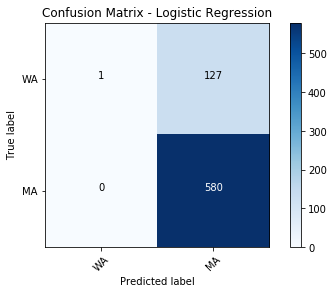

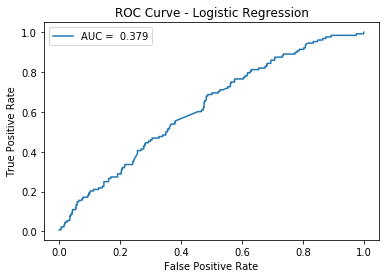

Accuracy = 0.821, Precision = 0.820, Recall = 1.000


In [34]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer

import re

class MyTokenizer(object):
    def __init__(self):
        self.stemmer = PorterStemmer()
        self.token_pattern = re.compile(u'(?u)\\b\\w\\w+\\b')
        
    def __call__(self, doc):
        return [self.stemmer.stem(w) for w in self.token_pattern.findall(doc)]

vectorizer = CountVectorizer(min_df=3, stop_words=text.ENGLISH_STOP_WORDS, tokenizer=MyTokenizer()) 
tfidf_transformer = TfidfTransformer()

washington_terms = ['Seattle, Washington', 'Washington', 'WA', 'Seattle, WA', 'Kirkland, Washington']
massachusetts_terms = ['massachusetts', 'ma']

def find_location(loc):
    for wt in washington_terms:
        if loc.lower().find(wt.lower()) >= 0:
            return "washington" # 0
    for mt in massachusetts_terms:
        if loc.lower().find(mt.lower()) >= 0:
            return "massachusetts" # 1
    return None

X, y = [], []
for tweet in tweets_sb:
    location = find_location(tweet['tweet']['user']['location'])
    if location is None: continue # does not belong to either state
    X.append(tweet['tweet']['text'])
    y.append(0 if location == "washington" else 1)

X = vectorizer.fit_transform(X)
X = tfidf_transformer.fit_transform(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# print(X.shape, y.shape)
logistic = linear_model.LogisticRegression()
logistic.fit(X_train, y_train)
y_pred = logistic.predict(X_test)
y_pred_prob = logistic.predict_proba(X_test)
show_stats(y_test, y_pred, y_pred_prob)

In [35]:
def show_stats(y_test, y_pred, y_pred_prob):
    import itertools
    from sklearn import linear_model
    from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_score, accuracy_score, recall_score

    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

    cnf_matrix = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cnf_matrix, ['WA', 'MA'], title='Confusion Matrix - Logistic Regression')

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,0], pos_label=0)
    plt.plot(fpr, tpr, label='AUC =  %.3f' % roc_auc_score(y_test, y_pred_prob[:,0]))
    plt.title('ROC Curve - Logistic Regression')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.show()

    print('Accuracy = %.3f, Precision = %.3f, Recall = %.3f' % (accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred)))


b) Afterwards, we applied a more complex model of a Linear support vector machine.

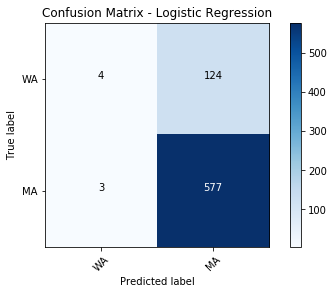

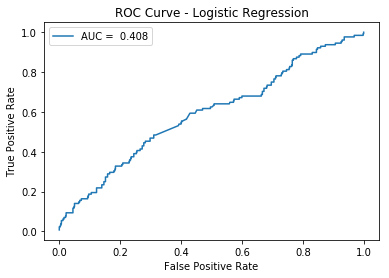

Accuracy = 0.821, Precision = 0.823, Recall = 0.995


In [40]:
from sklearn.svm import SVC

clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)
show_stats(y_test, y_pred, y_pred_prob)

c) Finally, we employed a multinomial Naive Bayes classifier. This type of model is suitable for classification with discrete features and in practice, fractional counts such as tf-idf representations also work, which is the case in our machine learning problem.

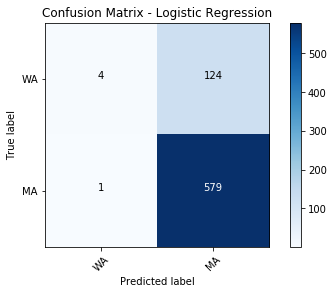

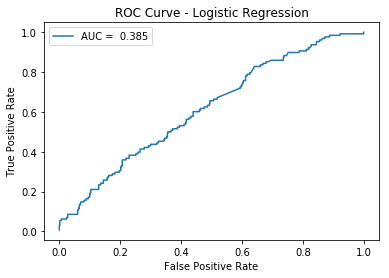

Accuracy = 0.823, Precision = 0.824, Recall = 0.998


In [42]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)
show_stats(y_test, y_pred, y_pred_prob)

Overall, comparing these three models' results, one can claim that...

# "put title here for your project's scope"